# Scalable GP Classification in 1D (w/ KISS-GP)

This example shows how to use a `GridInducingVariationalGP` module. This classification module is designed for when the inputs of the function you're modeling are one-dimensional.

The use of inducing points allows for scaling up the training data by making computational complexity linear instead of cubic.

In this example, we’re modeling a function that is periodically labeled cycling every 1/8 (think of a square wave with period 1/4)

This notebook doesn't use cuda, in general we recommend GPU use if possible and most of our notebooks utilize cuda as well.

Kernel interpolation for scalable structured Gaussian processes (KISS-GP) was introduced in this paper:
http://proceedings.mlr.press/v37/wilson15.pdf

KISS-GP with SVI for classification was introduced in this paper:
https://papers.nips.cc/paper/6426-stochastic-variational-deep-kernel-learning.pdf

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from math import exp

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
train_x = torch.linspace(0, 1, 26)
train_y = torch.sign(torch.cos(train_x * (2 * math.pi)))

In [3]:
class GPClassificationModel(gpytorch.models.GridInducingVariationalGP):
    def __init__(self):
        super(GPClassificationModel, self).__init__(grid_size=32, grid_bounds=[(0, 1)])
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(
                log_lengthscale_prior=gpytorch.priors.SmoothedBoxPrior(
                    exp(0), exp(3), sigma=0.1, log_transform=True
                )
            )
        )
        
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred


model = GPClassificationModel()
likelihood = gpytorch.likelihoods.BernoulliLikelihood()

In [4]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.SGD([
    {'params': model.parameters()},
    # BernoulliLikelihood has no parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
# n_data refers to the amount of training data
mll = gpytorch.mlls.VariationalMarginalLogLikelihood(likelihood, model, num_data=len(train_y))

def train():
    num_iter = 200
    for i in range(num_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f' % (i + 1, num_iter, loss.item()))
        optimizer.step()
        
# Get clock time
%time train()

Iter 1/200 - Loss: 6097.150
Iter 2/200 - Loss: 392.698
Iter 3/200 - Loss: 352.528
Iter 4/200 - Loss: 322.668
Iter 5/200 - Loss: 324.150
Iter 6/200 - Loss: 362.064
Iter 7/200 - Loss: 416.016
Iter 8/200 - Loss: 298.819
Iter 9/200 - Loss: 252.523
Iter 10/200 - Loss: 211.480
Iter 11/200 - Loss: 321.593
Iter 12/200 - Loss: 289.411
Iter 13/200 - Loss: 347.734
Iter 14/200 - Loss: 330.747
Iter 15/200 - Loss: 296.441
Iter 16/200 - Loss: 320.904
Iter 17/200 - Loss: 309.613
Iter 18/200 - Loss: 281.426
Iter 19/200 - Loss: 296.923
Iter 20/200 - Loss: 301.174
Iter 21/200 - Loss: 250.977
Iter 22/200 - Loss: 343.925
Iter 23/200 - Loss: 240.633
Iter 24/200 - Loss: 281.263
Iter 25/200 - Loss: 271.904
Iter 26/200 - Loss: 325.001
Iter 27/200 - Loss: 272.500
Iter 28/200 - Loss: 271.221
Iter 29/200 - Loss: 284.778
Iter 30/200 - Loss: 243.273
Iter 31/200 - Loss: 292.012
Iter 32/200 - Loss: 302.940
Iter 33/200 - Loss: 290.159
Iter 34/200 - Loss: 320.918
Iter 35/200 - Loss: 259.498
Iter 36/200 - Loss: 277.864


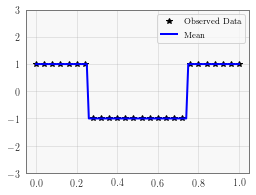

In [5]:
# Set model and likelihood into eval mode
model.eval()
likelihood.eval()

# Initialize axes
f, ax = plt.subplots(1, 1, figsize=(4, 3))

with torch.no_grad():
    test_x = torch.linspace(0, 1, 101)
    predictions = likelihood(model(test_x))

ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
pred_labels = predictions.mean.ge(0.5).float().mul(2).sub(1)
ax.plot(test_x.data.numpy(), pred_labels.numpy(), 'b')
ax.set_ylim([-3, 3])
ax.legend(['Observed Data', 'Mean', 'Confidence'])